In [1]:
import numpy as np
import math as mat
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
import imageio
from scipy.stats import wasserstein_distance
#%matplotlib notebook
#from sympy import *
#plt.rcParams['figure.figsize']=(5,3)
#plt.rcParams['figure.dpi'] = 150

In [2]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))


def dsigmoid(x):
    y = sigmoid(x)
    return y * (1. - y)


def dtanh(x):
    return 1. - np.tanh(x) ** 2


def lrelu(x, alpha=1e-2):
    return np.maximum(x, x * alpha)


def dlrelu(x, alpha=1e-2):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

In [3]:
#Data Generation

m = 2000
#X = np.random.normal(0,1,size=[m, 1])
X = np.random.uniform(0,1,(m, 1))

dataset = np.random.beta(0.5,0.5, size=[m,1])
#dataset = np.tanh(-5*lrelu(1*X+0)-5*lrelu(-1*X+0)+2)

#dataset = np.random.normal(10,1,size=[m,1])

#dataset = 5* lrelu(1*X - 0.6) - 5*lrelu(-1*X + 0.4) + 10

#dataset = 8*lrelu(1*X - 0.7,0) - 8*lrelu(-1*X + 0.3,0) + 10

#dataset = -3.5*lrelu(1*X-0.5,0) - 3.5*lrelu(0.5-1*X,0) + 3.5*lrelu(-2*X+0.5,0) 

#dataset =  10/9* lrelu(1*X - 0.55,0) - 10/9*lrelu(-1*X + 0.45,0) + 2.5*lrelu(1*X - 0.8,0) - 2.5*lrelu(-1*X + 0.2,0)



def NormOnData(X):
    return (X - np.min(dataset))/(np.max(dataset)-np.min(dataset) + 1e-8)

def dNormOnData(X):
    return 1/(np.max(dataset)-np.min(dataset) + 1e-8)

def NormOnDataset2(X):
    return (np.max(dataset)-np.min(dataset))*(X-np.min(X))/(np.max(X)-np.min(X) + 1e-8) + np.min(dataset)


def dNormOnDataset(X):
    return (np.max(dataset)-np.min(dataset))/(np.max(X)-np.min(X) + 1e-8) 


def MinMaxN(X):
    return (X-np.min(X))/(np.max(X)-np.min(X) + 1e-8)


def dMinMaxN(X):
    return 1/(np.max(X)-np.min(X)+1e-8)


In [14]:
m = 3000
cluster1 = np.random.normal(0,1, size=[2*m//3,1])
cluster2 = np.random.normal(5,1, size=[m//3,1])

dataset = np.concatenate((cluster1,cluster2))


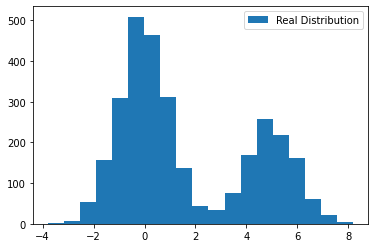

In [15]:
#Data set visualization
plt.hist(dataset, bins='auto', label='Real Distribution')
plt.legend(loc='upper right')
plt.show()

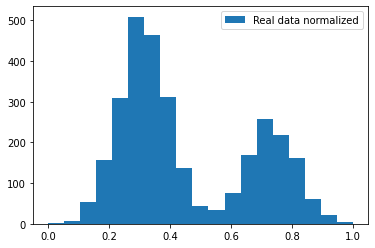

In [16]:
#Normalized Data visualization
plt.hist(MinMaxN(dataset), bins='auto', label='Real data normalized')
plt.legend(loc='upper right')
plt.show()

In [6]:
def initiate_parameters(nx_g, nh_g, inp_size, nh_d):
    
    # -------- Generator --------#
    W0_g = np.random.randn(nx_g, nh_g)* np.sqrt(2./nx_g)
    #W0_g = np.random.randn(nx_g, nh_g)
    b0_g = np.zeros((1, nh_g))
    #b0_g = np.random.normal(0,1,(1, nh_g))
    #b0_b = np.array([[2,-9]])

    W1_g = np.random.randn(nh_g, inp_size)* np.sqrt(2. / nh_g)
    #W1_g = np.random.randn(nh_g, inp_size)
    b1_g = np.zeros((1, inp_size))
    #b1_g = np.random.normal(0,1,(1, inp_size))


    W_g = [W0_g, W1_g]
    b_g = [b0_g, b1_g]

    # -------- Discriminator --------#
    W0_d = np.random.randn(inp_size, nh_d)* np.sqrt(2. / inp_size) 
    #W0_d = np.random.randn(inp_size, nh_d)
    #b0_d = np.random.randn(1, nh_d)
    b0_d = np.zeros((1,nh_d))

    W1_d = np.random.randn(nh_d, 1)* np.sqrt(2. / nh_d)
    #W1_d = np.random.randn(nh_d, 1)
    #b1_d = np.random.randn(1, 1)
    b1_d = np.zeros((1, 1))

    
    W_d = [W0_d, W1_d]
    b_d = [b0_d, b1_d]
    

    return W_g, b_g, W_d, b_d

In [7]:
def forward_generator(z, W_g, b_g):
    z_g = []
    a_g = []
    
    z0_g = np.dot(z, W_g[0]) + b_g[0]
    z_g.append(z0_g)
    #a0_g = sigmoid(z0_g)
    a0_g = lrelu(z0_g)
    a_g.append(a0_g)

    z1_g = np.dot(a0_g, W_g[1]) + b_g[1]
    z_g.append(z1_g)
    
    #a1_g = MinMaxN(z1_g)
    #a1_g = NormOnData(z1_g)
    #a1_g = np.tanh(z1_g)
    #a1_g = lrelu(z1_g)
    a1_g = sigmoid(z1_g)
    #a1_g = z1_g
    a_g.append(a1_g)

    return z_g, a_g


def forward_discriminator(x, W_d, b_d):
    z_d = []
    a_d = []
    
    z0_d = np.dot(x, W_d[0]) + b_d[0]
    z_d.append(z0_d)
    #a0_d = sigmoid(z0_d)
    a0_d = lrelu(z0_d)
    a_d.append(a0_d)

    z1_d = np.dot(a0_d, W_d[1]) + b_d[1]
    z_d.append(z1_d)
    #a1_d = sigmoid(z1_d)  
    a1_d = z1_d
    #a1_d = lrelu(z1_d)
    a_d.append(a1_d)
    return z_d, a_d

In [8]:
def preprocess_data(x, batch_size):
     
    
    x_train = np.reshape(x, (len(x),-1))
    x_train = MinMaxN(x_train)

    # limit the data to full batches only
    num_batches = x_train.shape[0] // batch_size
    x_train = x_train[: num_batches * batch_size]
    #x_train = MinMaxN(x_train)

    # normalise the data to the range [-1,1] = [a,b]
    # X' = a + (b-a)(X-Xmin)/(Xmax-Xmin)
    #x_train = -1+2*(x_train-x_train.min())/(x_train.max()-x_train.min())

    # shuffle the data
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    return x_train, num_batches

In [9]:
def shuffle_data(x_train):
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    return x_train

In [10]:
def backpropagation_D(x_real, a_real, z_real, x_fake, a_fake, z_fake, W_d, der_activation):
    
    m_r = len(x_real)
    m_f = len(x_fake)
    
    a1_real = a_real[-1]
    a0_dr = a_real[0]
    z1_real = z_real[-1]
    z0_dr = z_real[0]
    
    a1_fake = a_fake[-1]
    a0_df = a_fake[0]
    z1_fake = z_fake[-1]
    z0_df = z_fake[0]
    
    # cost_D = - np.mean(a_d_real[-1]) + np.mean(a_d_fake[-1])
    
    #real input cost derivative = -1         
    da1_real = -1.*np.ones(a1_real.shape)

    #dz1_real = da1_real * dsigmoid(z1_real)
    dz1_real = da1_real
    #dz1_real = da1_real * dlrelu(z1_real)
    dW1_real = np.dot(a0_dr.T, dz1_real)
    db1_real = np.sum(dz1_real, axis=0, keepdims=True)

    da0_real = np.dot(dz1_real, W_d[1].T)
    dz0_real = da0_real * der_activation(z0_dr)    
    dW0_real = np.dot(x_real.T, dz0_real)
    db0_real = np.sum(dz0_real, axis=0, keepdims=True)
        
    # fake input cost derivative =  1.
    da1_fake = 1.*np.ones(a1_fake.shape)

    #dz1_fake = da1_fake * dsigmoid(z1_fake)
    dz1_fake = da1_fake 
    #dz1_fake = da1_fake * dlrelu(z1_real)
    dW1_fake = np.dot(a0_df.T, dz1_fake)
    db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

    da0_fake = np.dot(dz1_fake, W_d[1].T)
    dz0_fake = da0_fake * der_activation(z0_df)
    dW0_fake = np.dot(x_fake.T, dz0_fake)
    db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

    # -------- Combine gradients for real & fake images--------#
    dW1 = dW1_real + dW1_fake
    db1 = db1_real + db1_fake

    dW0 = dW0_real + dW0_fake
    db0 = db0_real + db0_fake
    
    return dW0, db0, dW1, db1

In [11]:
def backpropagation_G(z, a_d, z_d, a_g, z_g, W_d, W_g, der_activation_D, der_activation_G):
    
    m_f = len(z)
    
    a1_fake = a_d[-1]
    z1_fake = z_d[-1]
    z0_d = z_d[0]
    
    z1_g = z_g[-1]
    a0_g = a_g[0]
    z0_g = z_g[0]

    # -------- Backprop through Discriminator --------#
    # cost_D = np.mean(a_d_real[-1]) - np.mean(a_d_fake[-1])

    # fake input derivative = -1.
    da1_d = -1.* np.ones(a1_fake.shape)

    #dz1_d = da1_d * dsigmoid(z1_fake)
    dz1_d = da1_d
    #dz1_d = da1_d * dlrelu(z1_fake)
    da0_d = np.dot(dz1_d, W_d[1].T)
    dz0_d = da0_d * der_activation_D(z0_d)
    dx_d = np.dot(dz0_d, W_d[0].T)

    # -------- Backprop through Generator --------#
    
    #dz1_g = dx_d
    dz1_g = dx_d * dsigmoid(z1_g)
    #dz1_g = dx_d * dtanh(z1_g)
    #dz1_g = dx_d * dlrelu(z1_g)
    #dz1_g = dx_d * dMinMaxN(z1_g)
    #dz1_g = dx_d * dNormOnData(z1_g)
    dW1_g = np.dot(a0_g.T, dz1_g)
    db1_g = np.sum(dz1_g, axis=0, keepdims=True)
    #db1_g = 0

    da0_g = np.dot(dz1_g, W_g[1].T)
    dz0_g = da0_g * der_activation_G(z0_g)
    dW0_g = np.dot(z.T, dz0_g)
    db0_g = np.sum(dz0_g, axis=0, keepdims=True)
    
    return dW0_g, db0_g, dW1_g, db1_g

In [19]:
J_Ds = []  # stores the disciminator losses
J_Gs = []  # stores the generator losses

beta = 0.01
epochs = 1000
batch_size = 100
nx_g = 10#input_layer_size_g
nh_g = 20 #hidden_layer_size_g
nh_d = 20 #hidden_layer_size_d
#input_layer_d = inp_size
#output_layer_d = 1
#output_layer_g = inp_size

ncritic = 10
c = 0.5
lr = 3e-3 #learning_rate
dr = 0e-4 #decay_rate
inp_size = len(dataset[0])

    
    # -------- Initialise weights with Xavier method --------#
W_g, b_g, W_d, b_d = initiate_parameters(nx_g, nh_g, inp_size, nh_d)
#W_g, b_g, _, _ = initiate_parameters(nx_g, nh_g, inp_size, nh_d)
    

#preprocess input -note that labels aren't needed
x_train, num_batches = preprocess_data(dataset, batch_size)

#moving average intialization
Sw_g = [np.zeros(W_g[0].shape), np.zeros(W_g[1].shape)]
Sb_g = [np.zeros(b_g[0].shape), np.zeros(b_g[1].shape)]
Sw_g_track = [Sw_g]
Sb_g_track = [Sb_g]


#moving average intialization
Sw_d = [np.zeros(W_d[0].shape), np.zeros(W_d[1].shape)]
Sb_d = [np.zeros(b_d[0].shape), np.zeros(b_d[1].shape)]
Sw_d_track = [Sw_d]
Sb_d_track = [Sb_d]

    
W_d_track = [W_d]
b_d_track = [b_d]
W_g_track = [W_g]
b_g_track = [b_g]
x_fake_track = []
dW_track = []
EM_dist = []


for epoch in range(epochs):
    #lr = 1/(50*epoch)
    lrG = 1*lr
    
    if epoch%(num_batches//ncritic)==0:
        x_train = shuffle_data(x_train)
    
    
    for n in range(ncritic):
        i = n + (epoch%(num_batches//ncritic))*ncritic
               
        # ------- PREPARE INPUT BATCHES & NOISE -------#
        x_real = x_train[i * batch_size: (i + 1) * batch_size]
        z = np.random.uniform(0,1, (batch_size, nx_g))
        
        
        # ------- FORWARD PROPAGATION -------#
        z_g, a_g = forward_generator(z, W_g, b_g)
        x_fake = a_g[-1]
        z_d_real, a_d_real = forward_discriminator(x_real, W_d, b_d)
        z_d_fake, a_d_fake = forward_discriminator(x_fake, W_d, b_d)
            
            
        # Discriminator backpropagation
        dW0, db0, dW1, db1 = backpropagation_D(x_real, a_d_real, z_d_real, x_fake, a_d_fake, z_d_fake, W_d, dlrelu)

        
        # --- Update through SGD ---#
        
        #W_d = [W_d[0] - lr * dW0, W_d[1] - lr * dW1]
        #b_d = [b_d[0] - lr * db0, b_d[1] - lr * db1]
        
        # --- Update through RMSprop --- #
           
        Sw_d = [beta*Sw_d[0]+(1-beta)*(dW0**2), beta*Sw_d[1]+(1-beta)*(dW1**2)]
        Sb_d = [beta*Sb_d[0]+(1-beta)*(db0**2), beta*Sb_d[1]+(1-beta)*(db1**2)]
            
        Sw_d_track.append(Sw_d)
        Sb_d_track.append(Sb_d)
        
        W_d = [W_d[0] - (lr * dW0)/(np.sqrt(Sw_d[0]+1e-8)), W_d[1] - (lr * dW1)/(np.sqrt(Sw_d[1]+1e-8))]
        b_d = [b_d[0] - (lr * db0)/(np.sqrt(Sb_d[0]+1e-8)), b_d[1] - (lr * db1)/(np.sqrt(Sb_d[1]+1e-8))]
        
             
        #clipping
        W_d = [np.clip(w,-c,c) for w in W_d]
        b_d = [np.clip(w,-c,c) for w in b_d]
        
    # ------- WASSERSTEIN LOSS -------#
    J_D = np.mean(a_d_real[-1]) - np.mean(a_d_fake[-1])
    J_Ds.append(J_D)
    
    r_dis = np.reshape(x_real, (len(x_real),))
    f_dis = np.reshape(x_fake, (len(x_fake),))
    
    
    EM_dist.append(wasserstein_distance(r_dis, f_dis))
    
    
    # Generator backpropagation 
        
    #z = np.random.uniform(0,1, (batch_size, nx_g))
    #z_g, a_g = forward_generator(z, W_g, b_g)
    #x_fake = a_g[-1]
    #z_d_fake, a_d_fake = forward_discriminator(x_fake, W_d, b_d)
    J_G = -np.mean(a_d_fake[-1])
    J_Gs.append(J_G)
       
    dW0_g, db0_g, dW1_g, db1_g = backpropagation_G(z, a_d_fake, z_d_fake, a_g, z_g, W_d, W_g, dlrelu, dlrelu)
        
        
    # ---Update through SGD ---#
        
    #W_g = [W_g[0] - lrG * dW0_g, W_g[1] - lrG * dW1_g]
    #b_g = [b_g[0] - lrG * db0_g, b_g[1] - lrG * db1_g]
        
    # --- Update through RMSporop ---#
        
    
    Sw_g = [beta*Sw_g[0]+(1-beta)*(dW0_g**2), beta*Sw_g[1]+(1-beta)*(dW1_g**2)]
    Sb_g = [beta*Sb_g[0]+(1-beta)*(db0_g**2), beta*Sb_g[1]+(1-beta)*(db1_g**2)]
        
    Sw_g_track.append(Sw_g)
    Sb_g_track.append(Sb_g)
        
    W_g = [W_g[0] - (lr * dW0_g)/(np.sqrt(Sw_g[0]+1e-8)), W_g[1] - (lr * dW1_g)/(np.sqrt(Sw_g[1]+1e-8))]
    b_g = [b_g[0] - (lr * db0_g)/(np.sqrt(Sb_g[0]+1e-8)), b_g[1] - (lr * db1_g)/(np.sqrt(Sb_g[1]+1e-8))]
    
    
    
     
        
    if epoch%10 == 1:
        W_d_track.append(W_d)
        b_d_track.append(b_d)
        W_g_track.append(W_g)
        b_g_track.append(b_g)
        x_fake_track.append(x_fake)
        
        dW_track.append(dW1)
        
        
    # reduce learning rate after every epoch
    lr = lr * (1.0 / (1.0 + dr * epoch))


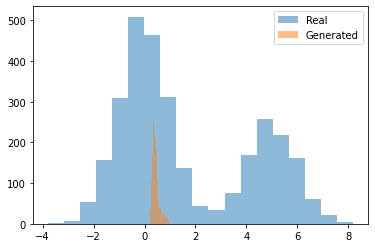

In [20]:
#z = np.random.normal(0, 1, size=[1000, 1])
z = np.random.uniform(0,1, (m, nx_g))
gen_samples, gen_samplesN = forward_generator(z, W_g, b_g)

#plt.hist(datasetN, bins = 'auto', alpha=0.5, label='Real')
plt.hist(dataset, bins = 'auto', alpha=0.5, label='Real')
plt.hist(gen_samplesN[-1], bins = 'auto', alpha=0.5, label='Generated')
plt.legend(loc='upper right')
plt.show()

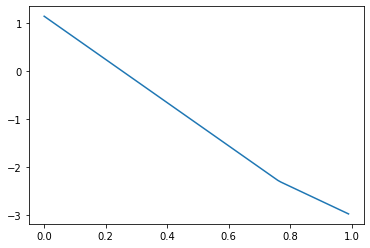

In [102]:
x = np.arange(0.,1.,0.01)
X = np.reshape(x,(len(x),1))
plt.plot(x, forward_discriminator(X, W_d, b_d)[-1][-1])

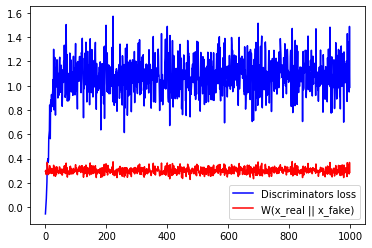

In [103]:
plt.plot(J_Ds, 'b', label='Discriminators loss')
plt.plot(EM_dist, 'r', label = 'W(x_real || x_fake)')
#plt.plot(J_Gs[0:600], 'r', label = 'Generators loss')
plt.legend()
plt.show()

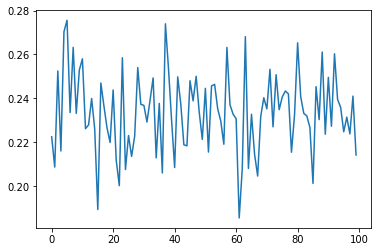

In [32]:
plt.plot(EM_dist)